# CNN model to detect anc localise sources

## Collect source and background datasets

In [8]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import join, isfile

# info tables
src_info = f'/data01/homes/dipiano/E4/crab/sim/merged_data.dat'
bkg_info = f'/data01/homes/dipiano/E4/background/sim/merged_data.dat'

# datasets path
src_dataset_path = f'/data01/homes/dipiano/E4/crab/sim'
bkg_dataset_path = f'/data01/homes/dipiano/E4/background/sim'
datapath = {'SRC': src_dataset_path, 'BKG': bkg_dataset_path}

# datasets files
datafiles = {'SRC': [], 'BKG': []}
classes = datafiles.keys()
print(f"Classes: {classes}\n")
for k in classes:
    print(f"Class {k} data from: {datapath[k]}")
    datafiles[k] = sorted([join(datapath[k], f) for f in listdir(datapath[k]) if '.fits' in f and isfile(join(datapath[k], f))])
    
print(f"\nSRC dataset size: {len(datafiles['SRC'])}")
print(f"BKG dataset size: {len(datafiles['BKG'])}")

Classes: dict_keys(['SRC', 'BKG'])

Class SRC data from: /data01/homes/dipiano/E4/crab/sim
Class BKG data from: /data01/homes/dipiano/E4/background/sim

SRC dataset size: 50000
BKG dataset size: 50000


## Utility functions

In [9]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
from scipy.ndimage import gaussian_filter

# extract heatmap from DL3 with configurable exposure
def extract_heatmap(data, trange, smoothing, nbins, save=False, save_name=None):
    data = data[(data['TIME'] >= trange[0]) & (data['TIME'] <= trange[1])] 
    ra = data['RA'].to_numpy()
    dec = data['DEC'].to_numpy()
    heatmap, xe, ye = np.histogram2d(ra, dec, bins=nbins)
    heatmap = gaussian_filter(heatmap, sigma=smoothing)
    if save and save_name is not None:
        np.save(save_name, heatmap, allow_pickle=True, fix_imports=True)
    return heatmap.T

# normalise single heatmap between 0 and 1
def normalise_heatmap(heatmap, save=False, save_name=None):
    min_value = np.min(heatmap)
    max_value = np.max(heatmap)
    norm_parameters = {'min': min_value, 'max': max_value}
    heatmap = (heatmap - min_value) / (max_value - min_value)
    if save and save_name is not None:
        np.save(save_name, heatmap, allow_pickle=True, fix_imports=True)
    return heatmap

# plot heatmap
def plot_heatmap(heatmap, title='heatmap', norm='linear', show=False, save=False, save_name=None):
    plt.figure()
    plt.title(title)
    if norm == 'linear':
        plt.imshow(heatmap, vmin=0, vmax=1)
    elif norm == 'log':
        plt.imshow(heatmap, norm=SymLogNorm(1, base=10), vmin=0, vmax=1)
    plt.xlabel('x(det) [pixels]')
    plt.ylabel('y(det) [pixels]')
    plt.colorbar()
    if save and save_name is not None:
        plt.savefig(save_name)
    if show:
        plt.show()
    plt.close()
    return

## Parameters and execution options

In [12]:
# map parameters
trange = [0, 50]
exposure = trange[1] - trange[0]
smoothing = 3
pixelsize = 0.02
nbins = int(5/pixelsize)
# execution options
plot_data = True
show_plot = False
save_plot = True
normalise_data = True
save_map = True
save_norm = True
reshape = True
save_reshape = False
# dataset split
class_sample = 1000 # total size of single-class dataset
class_train_sample = 800 # size of train single-class dataset
class_test_sample = class_sample - class_train_sample # size of test single-class dataset
total_train_size = class_train_sample * 2 # total size of full train dataset 
total_test_size = class_test_sample * 2 # total size of full test dataset 

## Load and normalise dataset

In [11]:
# gather data
datasets = {'SRC': [], 'BKG': []}
for k in classes:
    print(f"\nLoad {k} data...")
    for idx, f in enumerate(tqdm(datafiles[k][:class_sample])):
        # load
        heatmap = Table.read(f, hdu=1).to_pandas()
        # integrate exposure
        heatmap = extract_heatmap(heatmap, trange, smoothing, nbins, save=save_map, save_name=datafiles[k][idx].replace('.fits', f'_{exposure}s.npy'))
        # plot map
        if plot_data:
            plot_heatmap(heatmap, title='original', show=show_plot, save=save_plot, save_name=datafiles[k][idx].replace('.fits', f'_{exposure}s.png'))
        # normalise map
        if normalise_data:
            heatmap = normalise_heatmap(heatmap, save=save_norm, save_name=datafiles[k][idx].replace('.fits', f'_{exposure}s_normed.npy'))
        # plot normalised map
        if plot_data:
            plot_heatmap(heatmap, title='normalised', show=show_plot, save=save_plot, save_name=datafiles[k][idx].replace('.fits', f'_{exposure}s_normed.png'))
        # add to dataset
        datasets[k].append(heatmap)
        
print(f"DATASET {datasets.keys()}")
print(f"Sample SRC maps: {len(datasets['SRC'])}")
print(f"Sample BKG maps: {len(datasets['BKG'])}")


Load SRC data...


  0%|          | 0/1000 [00:00<?, ?it/s]


Load BKG data...


  0%|          | 0/1000 [00:00<?, ?it/s]

DATASET dict_keys(['SRC', 'BKG'])
Sample SRC maps: 1000
Sample BKG maps: 1000


### Display example images

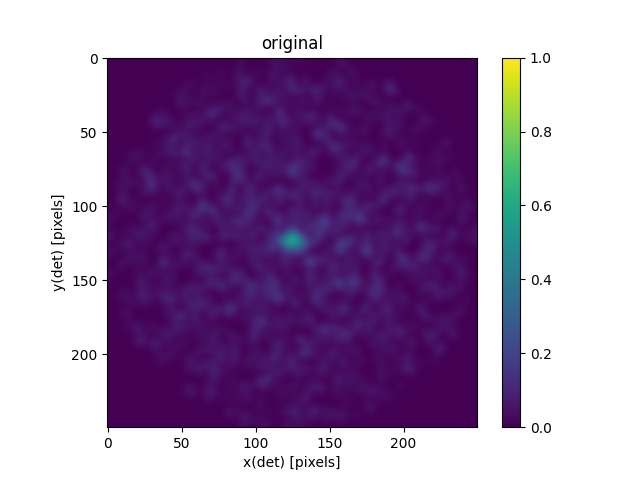

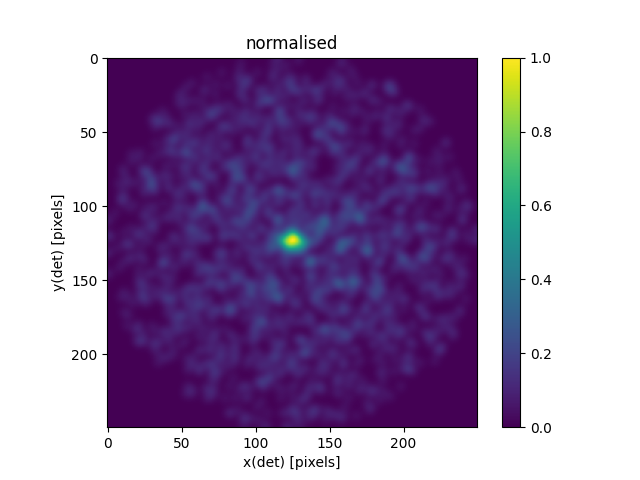

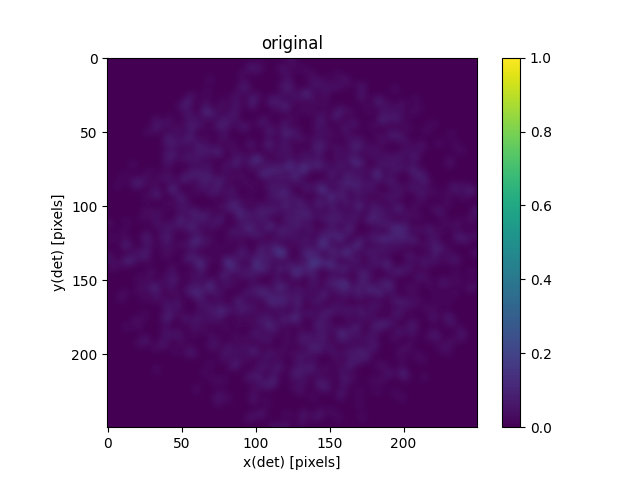

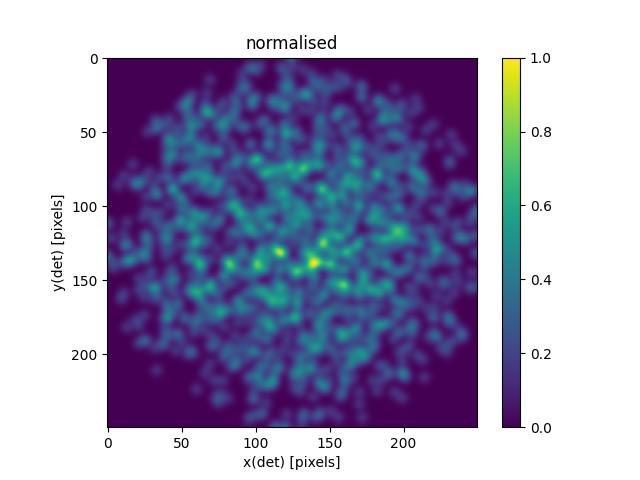

In [13]:
from IPython.display import Image
im1 = Image(filename='img/crab_00001_50s.png')
im2 = Image(filename='img/crab_00001_50s_normed.png')
im3 = Image(filename='img/background_00001_50s.png')
im4 = Image(filename='img/background_00001_50s_normed.png')

display(im1, im2, im3, im4)

### Split train and test datasets

In [17]:
train_data = np.empty((total_train_size, nbins, nbins))
train_labels = np.empty([total_train_size])
test_data = np.empty((total_test_size, nbins, nbins))
test_labels = np.empty([total_test_size])

train_src = np.copy(datasets['SRC'][:class_train_sample])
train_bkg = np.copy(datasets['SRC'][:class_train_sample])
train_data = np.append(train_src, train_bkg, axis=0) 

test_src = np.copy(datasets['SRC'][class_train_sample:])
test_bkg = np.copy(datasets['SRC'][class_train_sample:])
test_data = np.append(test_src, test_bkg, axis=0)

train_labels = np.array([1 for f in range(len(train_src))] + [0 for f in range(len(train_bkg))])
test_labels = np.array([1 for f in range(len(test_src))] + [0 for f in range(len(test_bkg))])

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

Train dataset: 1600, (1600, 250, 250)
Train labels: 1600, (1600,)

Test dataset: 400, (400, 250, 250)
Test labels: 400, (400,)


### Reshape train and test datasets

In [19]:
if reshape:
    train_data = train_data.reshape(train_data.shape[0], nbins, nbins, 1)
    test_data = test_data.reshape(test_data.shape[0], nbins, nbins, 1)
    train_labels = train_labels.reshape(train_data.shape[0], 1)
    test_labels = test_labels.reshape(test_data.shape[0], 1)
    
    if save_reshape:
        ds_path = src_dataset_path.replace('sim', '')
        np.save(join(ds_path, f'train_dataset_{exposure}.npy'), train_dataset, allow_pickle=True, fix_imports=True)
        np.save(join(ds_path, f'test_dataset_{exposure}.npy'), test_dataset, allow_pickle=True, fix_imports=True)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

Train dataset: 1600, (1600, 250, 250, 1)
Train labels: 1600, (1600, 1)

Test dataset: 400, (400, 250, 250, 1)
Test labels: 400, (400, 1)


In [20]:
train_data[0].shape
len(train_data[0]), train_data[0].shape

(250, (250, 250, 1))

## Load TensorBoard

In [21]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Create CNN Model

In [66]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
TF_CPP_MIN_LOG_LEVEL="1"

# create TF dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# create model
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(2, (5, 5), activation='relu', input_shape=(250, 250, 1), name='conv2d_1'))
model.add(layers.MaxPooling2D((2, 2), name='maxpool2d_1'))
model.add(layers.Conv2D(2, (5, 5), activation='relu', name='conv2d_2'))
model.add(layers.MaxPooling2D((2, 2), name='maxpool2d_2'))
model.add(layers.Conv2D(2, (5, 5), activation='relu', name='conv2d_3'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 246, 246, 2)       52        
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 123, 123, 2)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 119, 119, 2)       102       
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 59, 59, 2)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 2)         102       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 246, 246, 2)       52        
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 123, 123, 2)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 119, 119, 2)       102       
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 59, 59, 2)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 2)         102       
                                                                 
 flatten_10 (Flatten)        (None, 6050)              0         
                                                                 
 dense_17 (Dense)            (None, 50)               

### TensorBoard callback

In [68]:
log_dir = "logs/cnn-v01/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Compile the model

In [69]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Logdir and tensorboard callback

### Train the model

In [70]:
# when not specified batch_size = 32
model.fit(x=train_data, y=train_labels, epochs=5, validation_data=(test_labels, test_labels), 
          callbacks=[tensorboard_callback])

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.4925WARNING:tensorflow:Model was constructed with shape (None, 250, 250, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 250, 250, 1), dtype=tf.float32, name='conv2d_1_input'), name='conv2d_1_input', description="created by layer 'conv2d_1_input'"), but it was called on an input with incompatible shape (None, 1).


ValueError: in user code:

    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/input_spec.py", line 251, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer 'sequential_8' (type Sequential).
    
    Input 0 of layer "conv2d_1" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'sequential_8' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=int64)
      • training=False
      • mask=None


In [ ]:
%tensorboard --logdir logs/cnn-v01 --port 6006